# Lab: Classification for Prosper Loan Dataset

We are going to classify the prosper loan dataset.  This dataset shows a history of loans made by Prosper.

In [1]:
## Determine if we are running on google colab

try:
    import google.colab
    RUNNING_IN_COLAB = True
except:
    RUNNING_IN_COLAB = False

print ("Running in Google COLAB : ", RUNNING_IN_COLAB)


Running in Google COLAB :  False


In [2]:
%matplotlib inline
import time,datetime
import pandas as pd
import matplotlib.pyplot as plt

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ("tf version: ", tf.__version__)
print ("keras version: ", keras.__version__)

tf version:  2.1.0
keras version:  2.2.4-tf


## TF-GPU Debug
The following block tests if TF is running on GPU.

In [3]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU


import os, sys

## disable info logs from TF
#   Level | Level for Humans | Level Description                  
#  -------|------------------|------------------------------------ 
#   0     | DEBUG            | [Default] Print all messages       
#   1     | INFO             | Filter out INFO messages           
#   2     | WARNING          | Filter out INFO & WARNING messages 
#   3     | ERROR            | Filter out all messages 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
tf.get_logger().setLevel('WARN')


## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Step 1: Load the Data

Notice we are first loading this into a Pandas dataframe. This is fine for a small dataset, but we will need more than this for a large "at scale" notebook.

In [4]:
## small file, start with this
#datafile = "https://s3.amazonaws.com/elephantscale-public/data/prosper-loan/prosper-loan-data-sample.csv"

## this is a large file
datafile = "../data/prosper-loan/prosper-loan-data.csv.gz"

if RUNNING_IN_COLAB:
    datafile = "https://s3.amazonaws.com/elephantscale-public/data/prosper-loan/prosper-loan-data.csv.gz"


data = pd.read_csv(datafile)
data

,Term,LoanStatus,BorrowerRate,ProsperRating (numeric),ProsperScore,ListingCategory,BorrowerState,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,...,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,YearsWithCredit
0,36,1,0.1580,4.0,6.0,Unknown,CO,Self-employed,2.0,True,...,0.0,0.0,0.00,9425,330.43,0,0,0.0,258,13
1,36,1,0.1325,4.0,6.0,Unknown,Unknown,Full-time,19.0,False,...,0.0,0.0,0.00,1000,33.81,0,0,0.0,53,14
2,36,0,0.1435,5.0,4.0,Debt,AL,Employed,1.0,False,...,0.0,0.0,0.00,4000,137.39,0,0,0.0,1,18
3,36,0,0.3177,1.0,5.0,Household,FL,Other,121.0,True,...,0.0,0.0,0.00,4000,173.71,0,0,0.0,10,15
4,36,1,0.2075,4.0,6.0,Unknown,MI,Full-time,36.0,False,...,0.0,0.0,0.00,3000,112.64,0,0,0.0,53,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49719,36,1,0.0679,4.0,6.0,Personal,WA,Full-time,69.0,True,...,0.0,1000.0,847.61,4292,132.11,2,0,0.0,194,42
49720,36,1,0.1899,4.0,6.0,Business,CO,Full-time,22.0,False,...,0.0,14250.0,0.02,2000,73.30,0,0,0.0,25,10
49721,36,1,0.2639,2.0,3.0,Reno,FL,Employed,25.0,False,...,0.0,0.0,0.00,2500,101.25,0,0,0.0,26,6
49722,36,0,0.1110,6.0,8.0,Other,PA,Employed,21.0,True,...,0.0,33501.0,4815.42,2000,65.57,0,0,0.0,22,22


## Step 2 : Explore Data

In [5]:
prosper_clean = data.dropna()

print("Original record count {:,}, cleaned records count {:,},  dropped {:,}"\
      .format(len(data), len(prosper_clean), 
              (len(data) - len(prosper_clean))))
prosper_clean

Original record count 49,724, cleaned records count 49,724,  dropped 0


,Term,LoanStatus,BorrowerRate,ProsperRating (numeric),ProsperScore,ListingCategory,BorrowerState,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,...,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,YearsWithCredit
0,36,1,0.1580,4.0,6.0,Unknown,CO,Self-employed,2.0,True,...,0.0,0.0,0.00,9425,330.43,0,0,0.0,258,13
1,36,1,0.1325,4.0,6.0,Unknown,Unknown,Full-time,19.0,False,...,0.0,0.0,0.00,1000,33.81,0,0,0.0,53,14
2,36,0,0.1435,5.0,4.0,Debt,AL,Employed,1.0,False,...,0.0,0.0,0.00,4000,137.39,0,0,0.0,1,18
3,36,0,0.3177,1.0,5.0,Household,FL,Other,121.0,True,...,0.0,0.0,0.00,4000,173.71,0,0,0.0,10,15
4,36,1,0.2075,4.0,6.0,Unknown,MI,Full-time,36.0,False,...,0.0,0.0,0.00,3000,112.64,0,0,0.0,53,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49719,36,1,0.0679,4.0,6.0,Personal,WA,Full-time,69.0,True,...,0.0,1000.0,847.61,4292,132.11,2,0,0.0,194,42
49720,36,1,0.1899,4.0,6.0,Business,CO,Full-time,22.0,False,...,0.0,14250.0,0.02,2000,73.30,0,0,0.0,25,10
49721,36,1,0.2639,2.0,3.0,Reno,FL,Employed,25.0,False,...,0.0,0.0,0.00,2500,101.25,0,0,0.0,26,6
49722,36,0,0.1110,6.0,8.0,Other,PA,Employed,21.0,True,...,0.0,33501.0,4815.42,2000,65.57,0,0,0.0,22,22


In [6]:
print(prosper_clean['LoanStatus'].value_counts())

# 1 - paid
# 0 - defaulted

1    33530
0    16194
Name: LoanStatus, dtype: int64


In [7]:
print(prosper_clean['EmploymentStatus'].value_counts())


Full-time        25016
Employed         18393
Self-employed     3045
Part-time         1060
Other              924
Retired            703
Not employed       583
Name: EmploymentStatus, dtype: int64


In [8]:
print(prosper_clean['ListingCategory'].value_counts())

Debt             19107
Unknown           9335
Other             6272
Business          4449
Reno              3468
Personal          2392
Auto              1596
Student            756
Household          675
Medical            444
Taxes              246
Vacation           225
LargePurchase      224
Wedding            196
Motorcycle         103
Engagement          72
Cosmetic            47
Baby                46
Boat                30
Green               23
RV                  18
Name: ListingCategory, dtype: int64


## Step 3 - Shape Data

### 3.1 - Select Columns to consider

In [9]:
## categorical columns : These columns need to be encoded 
categorical_columns = ['ListingCategory', 'BorrowerState','EmploymentStatus']
label_column = ['LoanStatus']

## numeric columns : these columns will be scaled

## Approcah 1: We can manually define these columns

numeric_colums = ['Term', 'BorrowerRate', 'ProsperRating (numeric)', 'ProsperScore', 'EmploymentStatusDuration', 
                  'CreditScore', 'CurrentCreditLines', 'OpenCreditLines',  'YearsWithCredit'
                 ]

## Approach 2 : include every thing but categorical and label
numeric_colums = [c for c in prosper_clean.columns if c not in categorical_columns + label_column]

input_columns = categorical_columns + numeric_colums

print ('categorical columns: ', categorical_columns)
print ()
print ('numeric columns: ', numeric_colums)
print ()
print ("label column : ", label_column)

categorical columns:  ['ListingCategory', 'BorrowerState', 'EmploymentStatus']

numeric columns:  ['Term', 'BorrowerRate', 'ProsperRating (numeric)', 'ProsperScore', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CreditScore', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeVerifiable', 'StatedMonthlyIncome', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'LoanOriginalAmount', 'MonthlyLoanPayment'

In [10]:
print ("selected data:")
prosper_clean[label_column + input_columns]

selected data:


,LoanStatus,ListingCategory,BorrowerState,EmploymentStatus,Term,BorrowerRate,ProsperRating (numeric),ProsperScore,EmploymentStatusDuration,IsBorrowerHomeowner,...,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,YearsWithCredit
0,1,Unknown,CO,Self-employed,36,0.1580,4.0,6.0,2.0,True,...,0.0,0.0,0.00,9425,330.43,0,0,0.0,258,13
1,1,Unknown,Unknown,Full-time,36,0.1325,4.0,6.0,19.0,False,...,0.0,0.0,0.00,1000,33.81,0,0,0.0,53,14
2,0,Debt,AL,Employed,36,0.1435,5.0,4.0,1.0,False,...,0.0,0.0,0.00,4000,137.39,0,0,0.0,1,18
3,0,Household,FL,Other,36,0.3177,1.0,5.0,121.0,True,...,0.0,0.0,0.00,4000,173.71,0,0,0.0,10,15
4,1,Unknown,MI,Full-time,36,0.2075,4.0,6.0,36.0,False,...,0.0,0.0,0.00,3000,112.64,0,0,0.0,53,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49719,1,Personal,WA,Full-time,36,0.0679,4.0,6.0,69.0,True,...,0.0,1000.0,847.61,4292,132.11,2,0,0.0,194,42
49720,1,Business,CO,Full-time,36,0.1899,4.0,6.0,22.0,False,...,0.0,14250.0,0.02,2000,73.30,0,0,0.0,25,10
49721,1,Reno,FL,Employed,36,0.2639,2.0,3.0,25.0,False,...,0.0,0.0,0.00,2500,101.25,0,0,0.0,26,6
49722,0,Other,PA,Employed,36,0.1110,6.0,8.0,21.0,True,...,0.0,33501.0,4815.42,2000,65.57,0,0,0.0,22,22


### 3.1 - Encode Categorical Data

**Categorical data** can take on one of a limited, and usually fixed, number of possible values, assigning each individual or other unit of observation to a particular group or nominal category on the basis of some qualitative property. 

Here we will encode the 3 categorical data columns with **OneHotEncoder** *'ListingCategory', 'BorrowerState', and 'Employmentstatus'*  into numerical data for our model to be able to use this data.  One-hot encoding is a representation of categorical variables as binary vectors.  



In [11]:
from sklearn.preprocessing import OneHotEncoder

class categorical_encoder():
    def __init__(self):
        self.encoder = OneHotEncoder()
    def fit(self, data):
        self.encoder.fit(data)
        self.columns = data.columns
    def transform(self, data):    
        columns = list()
        for j,col in enumerate(self.columns):
            for val in self.encoder.categories_[j]:
                columns.append(col + '_is_' + str(val))
        return pd.DataFrame(self.encoder.transform(data).toarray(), dtype=bool, columns=columns)
    
category_encoder = categorical_encoder()

In [12]:
categorical_data = prosper_clean[categorical_columns]
categorical_data

,ListingCategory,BorrowerState,EmploymentStatus
0,Unknown,CO,Self-employed
1,Unknown,Unknown,Full-time
2,Debt,AL,Employed
3,Household,FL,Other
4,Unknown,MI,Full-time
...,...,...,...
49719,Personal,WA,Full-time
49720,Business,CO,Full-time
49721,Reno,FL,Employed
49722,Other,PA,Employed


In [13]:
category_encoder.fit(categorical_data)
categorical_data_encoded = category_encoder.transform(categorical_data)
categorical_data_encoded

,ListingCategory_is_Auto,ListingCategory_is_Baby,ListingCategory_is_Boat,ListingCategory_is_Business,ListingCategory_is_Cosmetic,ListingCategory_is_Debt,ListingCategory_is_Engagement,ListingCategory_is_Green,ListingCategory_is_Household,ListingCategory_is_LargePurchase,...,BorrowerState_is_WI,BorrowerState_is_WV,BorrowerState_is_WY,EmploymentStatus_is_Employed,EmploymentStatus_is_Full-time,EmploymentStatus_is_Not employed,EmploymentStatus_is_Other,EmploymentStatus_is_Part-time,EmploymentStatus_is_Retired,EmploymentStatus_is_Self-employed
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49719,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
49720,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
49721,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
49722,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


### Scale Numerical Data 

**Numerical data** is data that is measurable, such as time, height, weight, amount, and so on. You can help yourself identify numerical data by seeing if you can average or order the data in either ascending or descending order.

We will normalize the numerical data columns using **StandardScaler.**  StandardScaler, standardize features by removing the mean and scaling to unit variance.   

In [14]:
from sklearn.preprocessing import StandardScaler

numerical_data = prosper_clean[numeric_colums]
ss = StandardScaler()
numerical_data_scaled = pd.DataFrame(ss.fit_transform(numerical_data), columns = numerical_data.columns, dtype='float32')
numerical_data_scaled

,Term,BorrowerRate,ProsperRating (numeric),ProsperScore,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScore,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,...,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,YearsWithCredit
0,-0.168694,-0.551367,0.149991,-0.056228,-0.935411,1.017407,-0.640241,-0.823428,-0.876727,-0.966792,...,-0.045207,-0.377339,-0.287991,0.549795,0.524342,-0.208036,-0.148125,-0.083569,1.337146,-0.880409
1,-0.168694,-0.860579,0.149991,-0.056228,-0.735728,-0.982891,-0.640241,-1.361990,-1.278320,-1.107012,...,-0.045207,-0.377339,-0.287991,-1.048724,-1.068306,-0.208036,-0.148125,-0.083569,-0.502776,-0.746407
2,-0.168694,-0.727193,0.882114,-1.193217,-0.947157,-0.982891,-0.040655,-0.105346,-0.274337,0.225084,...,-0.045207,-0.377339,-0.287991,-0.479518,-0.512152,-0.208036,-0.148125,-0.083569,-0.969488,-0.210402
3,-0.168694,1.385151,-2.046378,-0.624722,0.462370,1.017407,0.259139,0.074174,0.127257,-0.546130,...,-0.045207,-0.377339,-0.287991,-0.479518,-0.317138,-0.208036,-0.148125,-0.083569,-0.888711,-0.612406
4,-0.168694,0.048869,0.149991,-0.056228,-0.536045,-0.982891,-0.940035,-1.002949,-0.876727,-0.896681,...,-0.045207,-0.377339,-0.287991,-0.669253,-0.645042,-0.208036,-0.148125,-0.083569,-0.502776,-1.148412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49719,-0.168694,-1.643917,0.149991,-0.056228,-0.148425,1.017407,1.158519,0.074174,-0.073540,-0.546130,...,-0.045207,-0.144046,0.161290,-0.424116,-0.540502,3.985066,-0.148125,-0.083569,0.762731,3.005631
49720,-0.168694,-0.164548,0.149991,-0.056228,-0.700490,-0.982891,0.858726,-1.002949,-1.077523,-0.756461,...,-0.045207,2.947090,-0.287981,-0.858988,-0.856272,-0.208036,-0.148125,-0.083569,-0.754082,-1.282413
49721,-0.168694,0.732774,-1.314255,-1.761712,-0.665252,-0.982891,-0.340448,-0.464387,-0.274337,-0.826571,...,-0.045207,-0.377339,-0.287991,-0.764121,-0.706199,-0.208036,-0.148125,-0.083569,-0.745107,-1.818419
49722,-0.168694,-1.121287,1.614236,1.080762,-0.712236,1.017407,0.259139,0.792257,0.930443,0.926187,...,-0.045207,7.438219,2.264452,-0.858988,-0.897776,-0.208036,-0.148125,-0.083569,-0.781008,0.325604


In [15]:
# x = prosper_clean [input_columns]
x = pd.concat([categorical_data_encoded, numerical_data_scaled], axis = 1)
y = prosper_clean[label_column]

print (y.head())
print('-----')
x

   LoanStatus
0           1
1           1
2           0
3           0
4           1
-----


,ListingCategory_is_Auto,ListingCategory_is_Baby,ListingCategory_is_Boat,ListingCategory_is_Business,ListingCategory_is_Cosmetic,ListingCategory_is_Debt,ListingCategory_is_Engagement,ListingCategory_is_Green,ListingCategory_is_Household,ListingCategory_is_LargePurchase,...,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,YearsWithCredit
0,False,False,False,False,False,False,False,False,False,False,...,-0.045207,-0.377339,-0.287991,0.549795,0.524342,-0.208036,-0.148125,-0.083569,1.337146,-0.880409
1,False,False,False,False,False,False,False,False,False,False,...,-0.045207,-0.377339,-0.287991,-1.048724,-1.068306,-0.208036,-0.148125,-0.083569,-0.502776,-0.746407
2,False,False,False,False,False,True,False,False,False,False,...,-0.045207,-0.377339,-0.287991,-0.479518,-0.512152,-0.208036,-0.148125,-0.083569,-0.969488,-0.210402
3,False,False,False,False,False,False,False,False,True,False,...,-0.045207,-0.377339,-0.287991,-0.479518,-0.317138,-0.208036,-0.148125,-0.083569,-0.888711,-0.612406
4,False,False,False,False,False,False,False,False,False,False,...,-0.045207,-0.377339,-0.287991,-0.669253,-0.645042,-0.208036,-0.148125,-0.083569,-0.502776,-1.148412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49719,False,False,False,False,False,False,False,False,False,False,...,-0.045207,-0.144046,0.161290,-0.424116,-0.540502,3.985066,-0.148125,-0.083569,0.762731,3.005631
49720,False,False,False,True,False,False,False,False,False,False,...,-0.045207,2.947090,-0.287981,-0.858988,-0.856272,-0.208036,-0.148125,-0.083569,-0.754082,-1.282413
49721,False,False,False,False,False,False,False,False,False,False,...,-0.045207,-0.377339,-0.287991,-0.764121,-0.706199,-0.208036,-0.148125,-0.083569,-0.745107,-1.818419
49722,False,False,False,False,False,False,False,False,False,False,...,-0.045207,7.438219,2.264452,-0.858988,-0.897776,-0.208036,-0.148125,-0.083569,-0.781008,0.325604


### 3.2 - Ensure Columns are in correct data type

In [16]:
## convert input columns to float
for col in x.columns:
    x[col] = x[col].astype('float32')
    
## convert label column to float as well
## As it turns out, we don't need to convert Y into float
# y = data[label_column].astype('float16')

print (y.head())
print('-----')
x

   LoanStatus
0           1
1           1
2           0
3           0
4           1
-----


,ListingCategory_is_Auto,ListingCategory_is_Baby,ListingCategory_is_Boat,ListingCategory_is_Business,ListingCategory_is_Cosmetic,ListingCategory_is_Debt,ListingCategory_is_Engagement,ListingCategory_is_Green,ListingCategory_is_Household,ListingCategory_is_LargePurchase,...,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,YearsWithCredit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.045207,-0.377339,-0.287991,0.549795,0.524342,-0.208036,-0.148125,-0.083569,1.337146,-0.880409
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.045207,-0.377339,-0.287991,-1.048724,-1.068306,-0.208036,-0.148125,-0.083569,-0.502776,-0.746407
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.045207,-0.377339,-0.287991,-0.479518,-0.512152,-0.208036,-0.148125,-0.083569,-0.969488,-0.210402
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.045207,-0.377339,-0.287991,-0.479518,-0.317138,-0.208036,-0.148125,-0.083569,-0.888711,-0.612406
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.045207,-0.377339,-0.287991,-0.669253,-0.645042,-0.208036,-0.148125,-0.083569,-0.502776,-1.148412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.045207,-0.144046,0.161290,-0.424116,-0.540502,3.985066,-0.148125,-0.083569,0.762731,3.005631
49720,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.045207,2.947090,-0.287981,-0.858988,-0.856272,-0.208036,-0.148125,-0.083569,-0.754082,-1.282413
49721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.045207,-0.377339,-0.287991,-0.764121,-0.706199,-0.208036,-0.148125,-0.083569,-0.745107,-1.818419
49722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.045207,7.438219,2.264452,-0.858988,-0.897776,-0.208036,-0.148125,-0.083569,-0.781008,0.325604


### 3.3 - Create train/test split

In [17]:
from sklearn.model_selection import train_test_split

# supply 'y1' (encoded labels)
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0) 

# backup
x_train_bak = x_train.copy(deep=True)
x_test_bak = x_test.copy(deep=True)

print ("x_train.shape : ", x_train.shape)
print ("y_train.shape : ", y_train.shape)
print ("x_test.shape : ", x_test.shape)
print ("y_test.shape : ", y_test.shape)

x_train.shape :  (39779, 122)
y_train.shape :  (39779, 1)
x_test.shape :  (9945, 122)
y_test.shape :  (9945, 1)


## Step 4 : Build the Model
Since this is a classifier, here is how we are going to build the neural network
- Neurons in Input layer  = input dimensions (4 here)
- Neurons in hidden layer = ???
- Neurons in Output layer = output classes (binary)
- Output activation is 'sigmoid'

**Optimizers** trains models fast, but it also prevents them from getting stuck in a local minimum. Optimizers are the engine of machine learning — they make the computer learn.

Here are the **optimizers** we will be working with and you can change:
- **RMSprop**, gradient-based optimization technique using a moving average of squared gradients to normalize the gradient itself
- **Adam**, is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks. The algorithms leverages the power of adaptive learning rates methods to find individual learning rates for each parameter.

### TODO : Sketch the neural net
- What is the input dimensions
- how many neurons in layers
- how many output neurons

<img src="../assets/images/neural-net-unknown.png" style="width:40%"/>

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7872      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 9,985
Trainable params: 9,985
Non-trainable params: 0
_________________________________________________________________
None


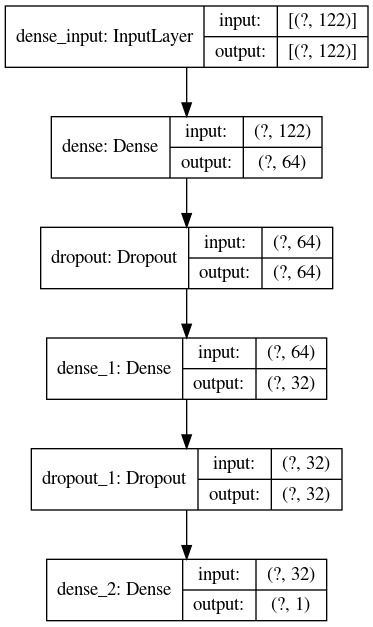

In [18]:
model = tf.keras.Sequential([
    # input layer is implicit
    tf.keras.layers.Dense(units=64, activation=tf.nn.relu, input_dim=x.shape[1]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    
        ## TODO : add more layers?
#     tf.keras.layers.Dense(units=16,activation=tf.nn.relu),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(8,activation=tf.nn.relu),
#     tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
  ])

# metrics = [
#     tf.keras.metrics.Accuracy(name='accuracy'),
#     tf.keras.metrics.TruePositives(name='tp'),
#     tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
#     tf.keras.metrics.FalseNegatives(name='fn'),
#     tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.Recall(name='recall'),
#     tf.keras.metrics.AUC(name='auc')
#   ]

metrics = ['accuracy' ]

optimizer = tf.keras.optimizers.RMSprop()
# optimizer=tf.keras.optimizers.RMSprop(lr=0.000001)
# optimizer = 'adam'

model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=metrics)

print(model.summary())

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Step 5 : Tensorboard

In [19]:
## This is fairly boiler plate code

import datetime
import os
import shutil

app_name = 'classification-prosper'

# tensorboard_logs_dir= os.path.join (tb_top_level_dir, app_name, 
#                                     datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S"))

tb_top_level_dir= '/tmp/tensorboard-logs'

tensorboard_logs_dir= os.path.join (tb_top_level_dir, app_name)


print ("Saving TB logs to : " , tensorboard_logs_dir)

#clear out old logs
shutil.rmtree ( os.path.join (tb_top_level_dir, app_name), ignore_errors=True )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_logs_dir, histogram_freq=1)

## This will embed Tensorboard right here in jupyter!
%load_ext tensorboard
%tensorboard --logdir $tensorboard_logs_dir

Saving TB logs to :  /tmp/tensorboard-logs/classification-prosper


## Step 6 : Train

In [20]:
%%time

epochs = 20

print ("training starting ...")
history = model.fit(
              x_train, y_train,
              epochs=epochs, validation_split = 0.2, verbose=1,
              callbacks=[tensorboard_callback])

print ("training done.")

training starting ...
Train on 31823 samples, validate on 7956 samples
Epoch 1/20
31823/31823 [==============================] - 3s 93us/sample - loss: 0.5756 - accuracy: 0.6914 - val_loss: 0.5522 - val_accuracy: 0.7069
Epoch 2/20
31823/31823 [==============================] - 2s 70us/sample - loss: 0.5538 - accuracy: 0.7102 - val_loss: 0.5517 - val_accuracy: 0.7130
Epoch 3/20
31823/31823 [==============================] - 2s 74us/sample - loss: 0.5458 - accuracy: 0.7163 - val_loss: 0.5494 - val_accuracy: 0.7130
Epoch 4/20
31823/31823 [==============================] - 2s 71us/sample - loss: 0.5429 - accuracy: 0.7195 - val_loss: 0.5496 - val_accuracy: 0.7114
Epoch 5/20
31823/31823 [==============================] - 2s 71us/sample - loss: 0.5405 - accuracy: 0.7214 - val_loss: 0.5466 - val_accuracy: 0.7164
Epoch 6/20
31823/31823 [==============================] - 2s 68us/sample - loss: 0.5376 - accuracy: 0.7239 - val_loss: 0.5482 - val_accuracy: 0.7182
Epoch 7/20
31823/31823 [===========

## Step 7 : Plot History

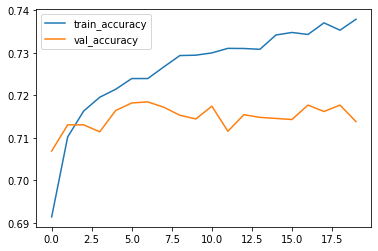

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='train_accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Step 8 : Predict

**predict**  will return the scores of the regression
 - Example 0.2 Completed and 0.6 Defaulted
   
**predict_classes**  will return the class of your prediction
 - Example borrower defaulted on loan(1) or borrower completed loan(0)

In [22]:
# predictions = model.predict(x_test)
# predictions

## Use 'predict_classes' instead of 'predict'
predictions = model.predict_classes(x_test)
predictions

array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

## Step 9 : Evaluate the model

### 9.1 - Print out metrics

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions > 0.5)

0.7180492709904475

In [24]:
metric_names = model.metrics_names
print ("model metrics : " , metric_names)

metrics = model.evaluate(x_test, y_test, verbose=0)

for idx, metric in enumerate(metric_names):
    print ("Metric : {} = {:,.2f}".format (metric_names[idx], metrics[idx]))

model metrics :  ['loss', 'accuracy']
Metric : loss = 0.55
Metric : accuracy = 0.72


### 9.2 - Confussion Matrix
Since this is a classification problem, confusion matrix is very effective way to evaluate our model

Visualizing the confusion matrix:

In [25]:
## plain confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predictions, labels = [0,1])
cm


array([[1240, 2044],
       [ 760, 5901]])

[]

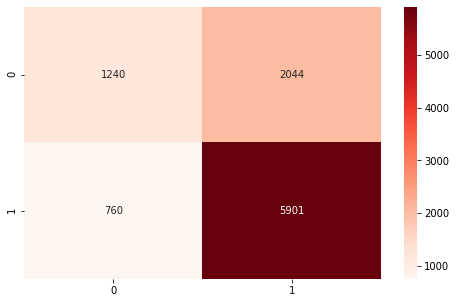

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8,5))

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm, annot=True, cmap="Reds", fmt='d').plot()

### 9.3 - Metrics calculated from Confusion Matrix

In [27]:
from sklearn.metrics import classification_report
from pprint import pprint

pprint(classification_report(y_test, predictions, output_dict=True))

{'0': {'f1-score': 0.4693414080242241,
       'precision': 0.62,
       'recall': 0.37758830694275275,
       'support': 3284},
 '1': {'f1-score': 0.808024099685061,
       'precision': 0.7427312775330397,
       'recall': 0.8859030175649302,
       'support': 6661},
 'accuracy': 0.7180492709904475,
 'macro avg': {'f1-score': 0.6386827538546425,
               'precision': 0.6813656387665199,
               'recall': 0.6317456622538414,
               'support': 9945},
 'weighted avg': {'f1-score': 0.6961855919511053,
                  'precision': 0.7022034227901033,
                  'recall': 0.7180492709904475,
                  'support': 9945}}


### TODO : Intepret confusion matrix
Instructor will walk you through the matrix.  
Answer these questions
- which class is classified correctly mostly
- which class is classified incorrectly?

## Step 10 : Improve the Model

Inspect the following
- What is the metric 'accuracy' in step 9.1
- And verify this with tensorboard (port 6066)

Most likely, we didn't get a great accuracy.  
How can we improve it?

**Try the following ideas** 

- **Idea-1 : Increase neurons in hidden layer**  
  - In Step-4, increase hidden layer neurons from 8 --> 64  
  - Click 'Kernel --> Restart and Run all Cells'  
  - Hopefully you should see improvement in the accuracy.  
  - Check  accuracy metrics / confusion matrix / tensorboard
- **Idea-2 : Increase epochs**
  - Increasing the epochs may cause cause your data to overfit
  - Look at time and how long it will take to run when increasing epochs
- **Idea-3 : Change optimizers** 
 - The optimizer interacts with the initialization scheme, so this might need to be changed.
 - The learning rate may need to be changed.
 - The learning rate schedule may need to be adjusted.
- **Idea-3 : Change scalers**
  - Try different scalers
  - Try data without using a scaler